# Vancouver Takeoff Data Source Code

## Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import math
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors
import time
from scipy.stats import linregress


## File Readings and Dataframe Creation

In [9]:
%%time
# Flights from Apr 16 to May 23
colormap = plt.colormaps['tab20']
subfolders = [f.path for f in os.scandir('data/vancouver/flight/') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
soh_list1 = []
soh_list2 = []
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []
df_pitch_list = []
df_roll_list = []
df_speed_list = []
df_soh_list = []
df_battT_list = []
power_sum = [0,0,0]
time_sum = [0,0,0]

# df_Dtime_list = []
# df_Dkw_list = []
# df_Dalt_list = []
# df_Dsoc_list = []
# df_Doat_list = []
# df_Dpitch_list = []
# df_Droll_list = []
# df_Dspeed_list = []

# Iterates and read each csv
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    if csv_files:
        # Reads the first csv file in each flight folder
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        # Skips every 10 rows for efficiency (1 sec iterations estimate)
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_soh = (df_csv[' bat 1 soh'] + df_csv[' bat 2 soh']) / 2
    df_soh_list.append(df_soh)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    df_pitch_list.append(df_csv[" PITCH"])
    df_roll_list.append(df_csv[" ROLL"])
    df_speed_list.append(df_csv[" GROUND_SPEED"])

    df_battT = 0
    for i in range(1, 17):
        df_battT += df_csv[f" bat 1 cell {i} temp"] 
        df_battT += df_csv[f" bat 2 cell {i} temp"] 
    df_battT = df_battT/32 
    df_battT_list.append(df_battT)
    
    
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
# for i, subfolder in enumerate(derated):
#     csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
#     print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
#     if csv_files:
#         # Reads the first csv file in each flight folder
#         main_csv = csv_files[0]
#         with open(main_csv) as f:
#             total_rows = sum(1 for line in f)
#         # Skips every 10 rows for efficiency (1 sec iterations estimate)
#         skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
#     df_Dcsv = pd.read_csv(main_csv,skiprows=skip_rows)
#     df_Dtime_list.append(df_csv[" time(min)"])
#     df_Dkw_list.append(df_csv[" motor power"])
#     df_Dsoc_list.append(df_csv[" bat 1 soc"])
#     df_Doat_list.append(df_csv[" OAT"])
#     df_Dpitch_list.append(df_csv[" PITCH"])
#     df_Droll_list.append(df_csv[" ROLL"])
#     df_Dspeed_list.append(df_csv[" GROUND_SPEED"])
    
#     # Calibrates alt to ground alt and converts m to ft
#     df_Dcsv[" PRESSURE_ALT"] = (df_Dcsv[" PRESSURE_ALT"]-df_Dcsv[" PRESSURE_ALT"].iloc[-1])*3.28084
#     df_Dcsv[" PRESSURE_ALT"] = df_Dcsv[" PRESSURE_ALT"].where(df_Dcsv[" PRESSURE_ALT"]>=0, 0)
#     df_Dalt_list.append(df_csv[" PRESSURE_ALT"])
    
        
    soh_list1.append(df_csv.loc[df_csv[' bat 1 soh'] != 0, ' bat 1 soh'].iloc[0])
    soh_list2.append(df_csv.loc[df_csv[' bat 2 soh'] != 0, ' bat 2 soh'].iloc[0])
df_soh1 = pd.DataFrame({"bat1": soh_list1})
df_soh2 = pd.DataFrame({"bat2": soh_list2})

# df_derated = pd.DataFrame({"time": df_Dtime_list, "kw": df_Dkw_list, "alt": df_Dalt_list, "soc": df_Dsoc_list, "oat": df_Doat_list, "pitch": df_Dpitch_list, "roll": df_Droll_list, "speed": df_Dspeed_list})

# Main df
df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list, "pitch": df_pitch_list, "roll": df_roll_list, "speed": df_speed_list, "soh": df_soh_list, "battT": df_battT_list})

print('') 

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/vancouver/flight/'

## Data Visualizations

### Altitude Data From All Flights

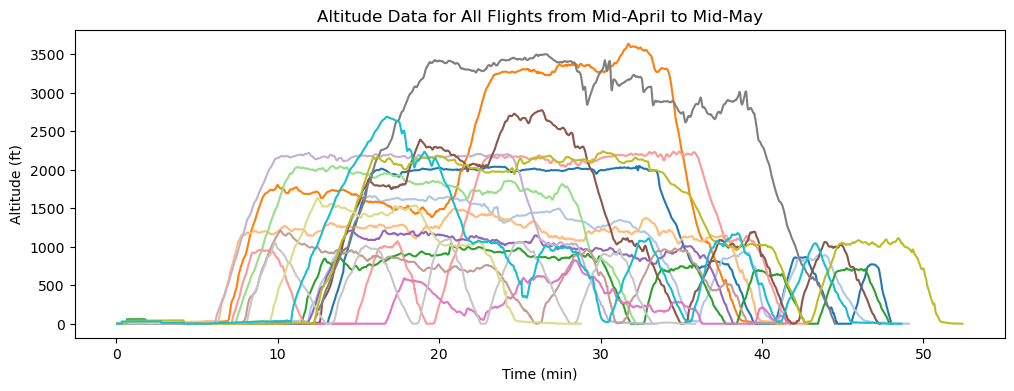

CPU times: total: 266 ms
Wall time: 686 ms


In [5]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')


plt.show()

### Circuit-Filtered Altitude Data 

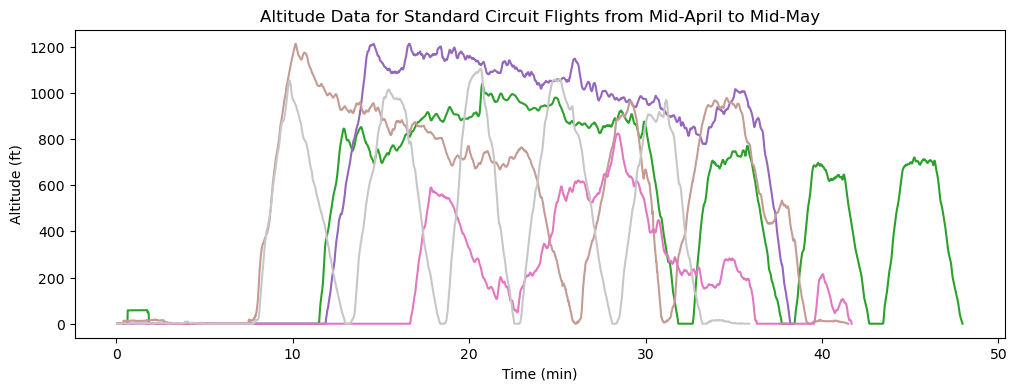

CPU times: total: 31.2 ms
Wall time: 389 ms


In [4]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1400:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

### Takeoff-Filtered Altitude Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Altitude per Time: 582.585 ft/min
Average Slope of Time per Altitude: 0.6 min/300 ft
Plotting...


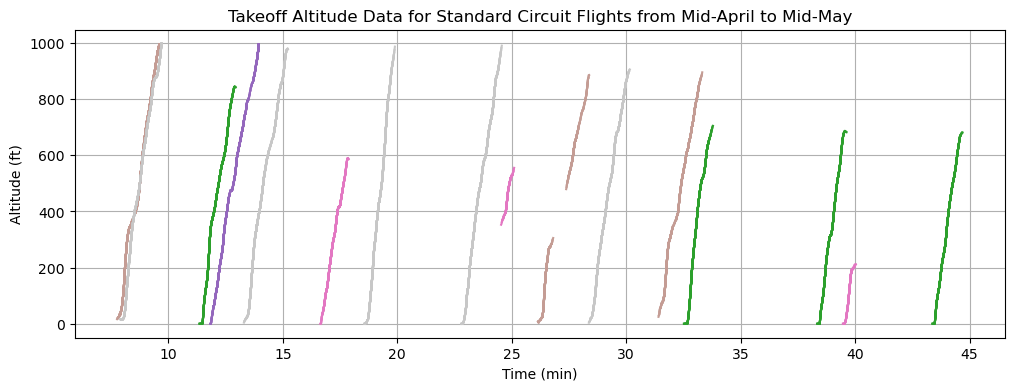

CPU times: total: 609 ms
Wall time: 3.19 s


In [5]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_ft_per_min = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                # Stops indexing at 1000 when end index is greater than 1000
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # Finds average slope
                diff_alt_data = np.diff(alt_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_ft_per_min = diff_alt_data[valid_indices] / diff_time_data[valid_indices]
                slopes_ft_per_min.extend(slope_ft_per_min)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_ft_per_min))
print(f"Average Slope of Altitude per Time: {round(average_slope_soc_per_ft,3)} ft/min")
print(f"Average Slope of Time per Altitude: {round(1/average_slope_soc_per_ft,3)*300} min/300 ft")
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.419 min/300 ft
Plotting...


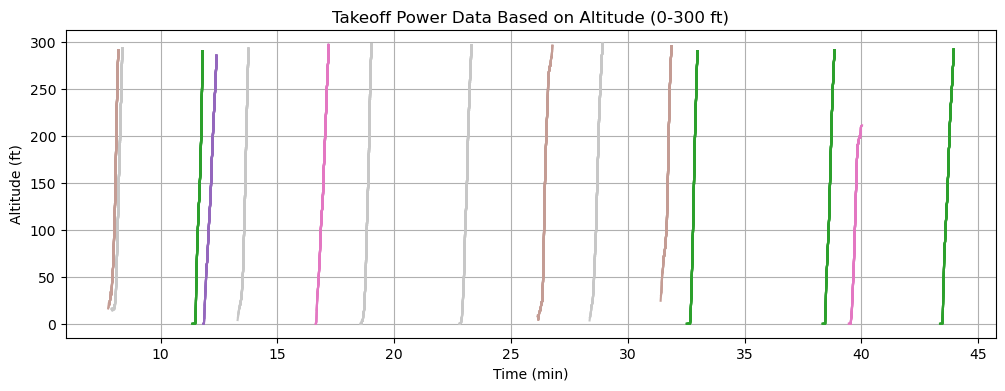

CPU times: total: 125 ms
Wall time: 1.66 s


In [6]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 400
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[0] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.528 min/300 ft
Plotting...


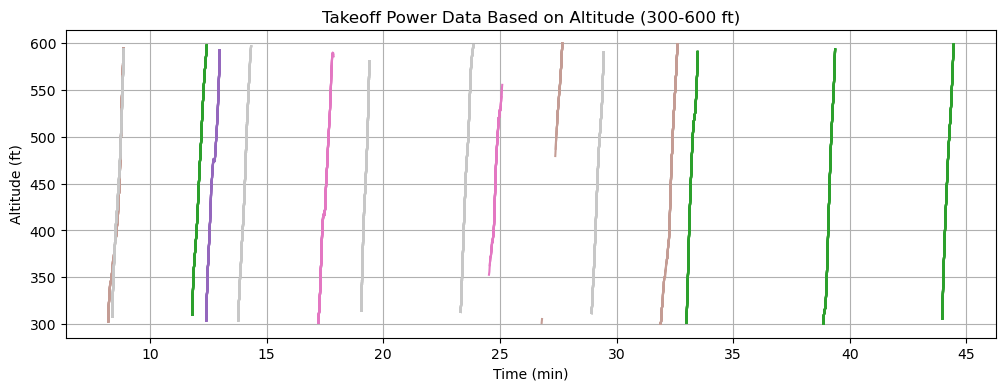

CPU times: total: 391 ms
Wall time: 2.11 s


In [7]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[1] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 0.572 min/300 ft
Plotting...


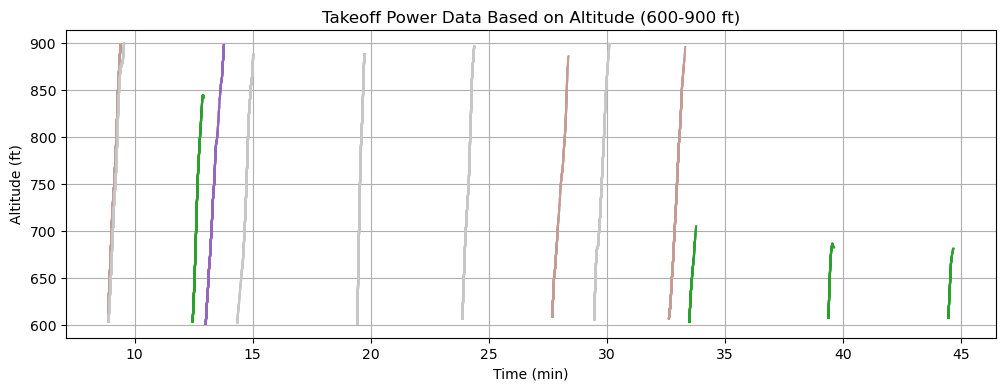

CPU times: total: 188 ms
Wall time: 1.7 s


In [8]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[2] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Takeoff Power Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


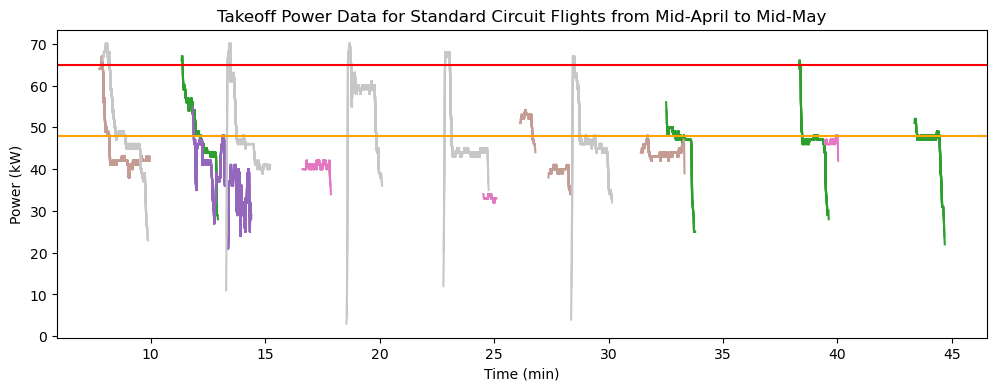

CPU times: total: 922 ms
Wall time: 2.78 s


In [9]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1400:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


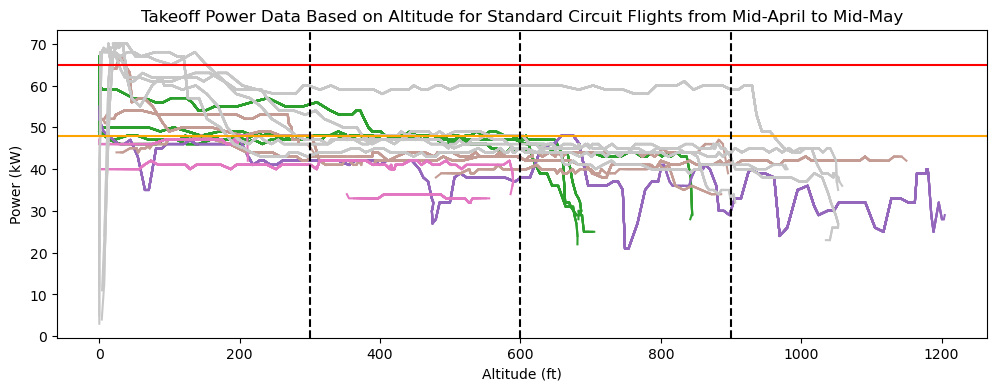

CPU times: total: 391 ms
Wall time: 2.7 s


In [10]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 50.607 kW
Plotting...


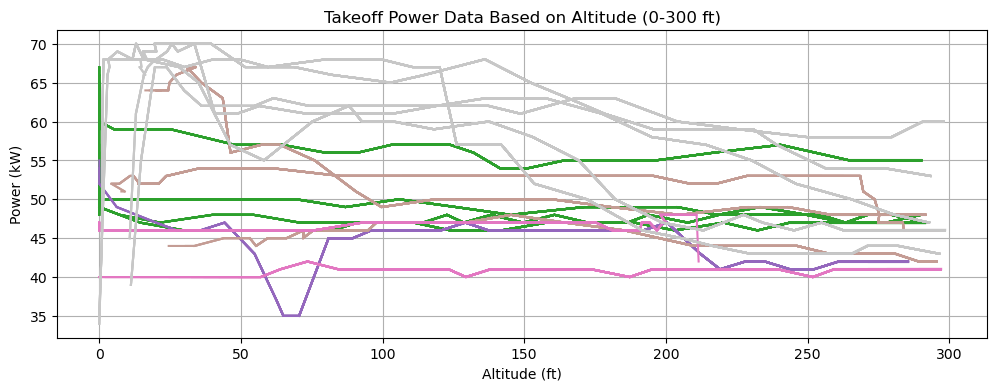

CPU times: total: 766 ms
Wall time: 2.38 s


In [11]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[0] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 45.925 kW
Plotting...


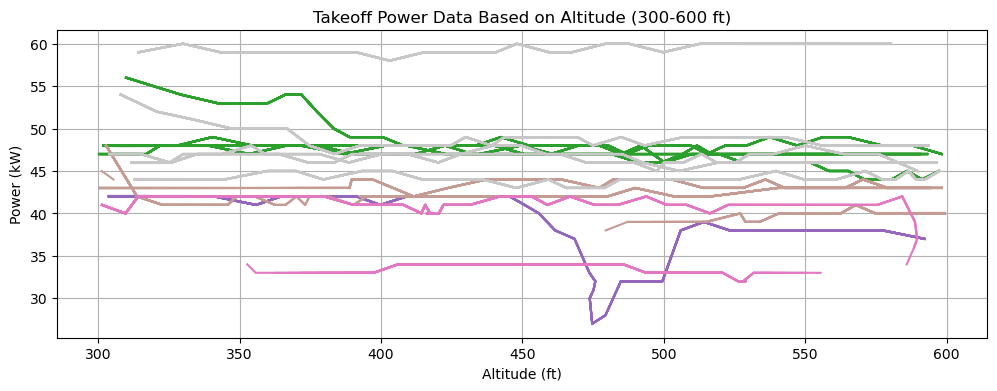

CPU times: total: 688 ms
Wall time: 2.46 s


In [12]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[1] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()



Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of Min per 300 ft: 43.884 kW
Plotting...


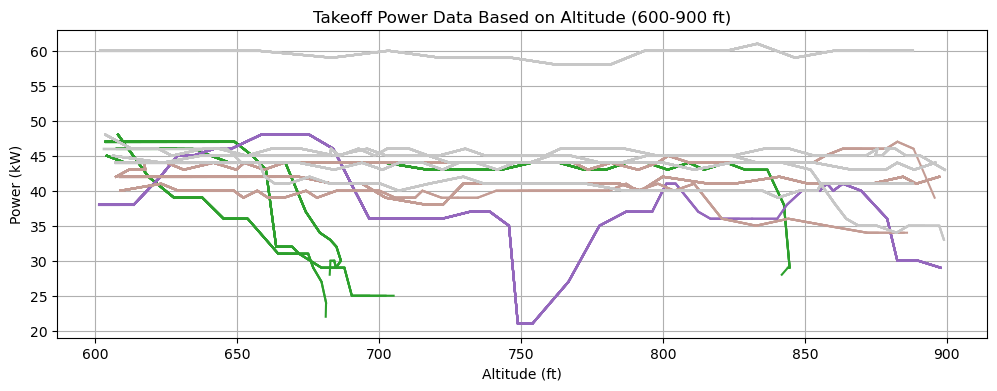

CPU times: total: 219 ms
Wall time: 1.63 s


In [13]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[2] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} min")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()



#### Power Seperated by OAT

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Power (OAT > 20°): 51.484 kW
Average Power (17.5°-20°): 52.586 kW
Average Power (15°-17.5°): 43.065 kW
Average Power (OAT < 15°): 49.667 kW
Plotting...


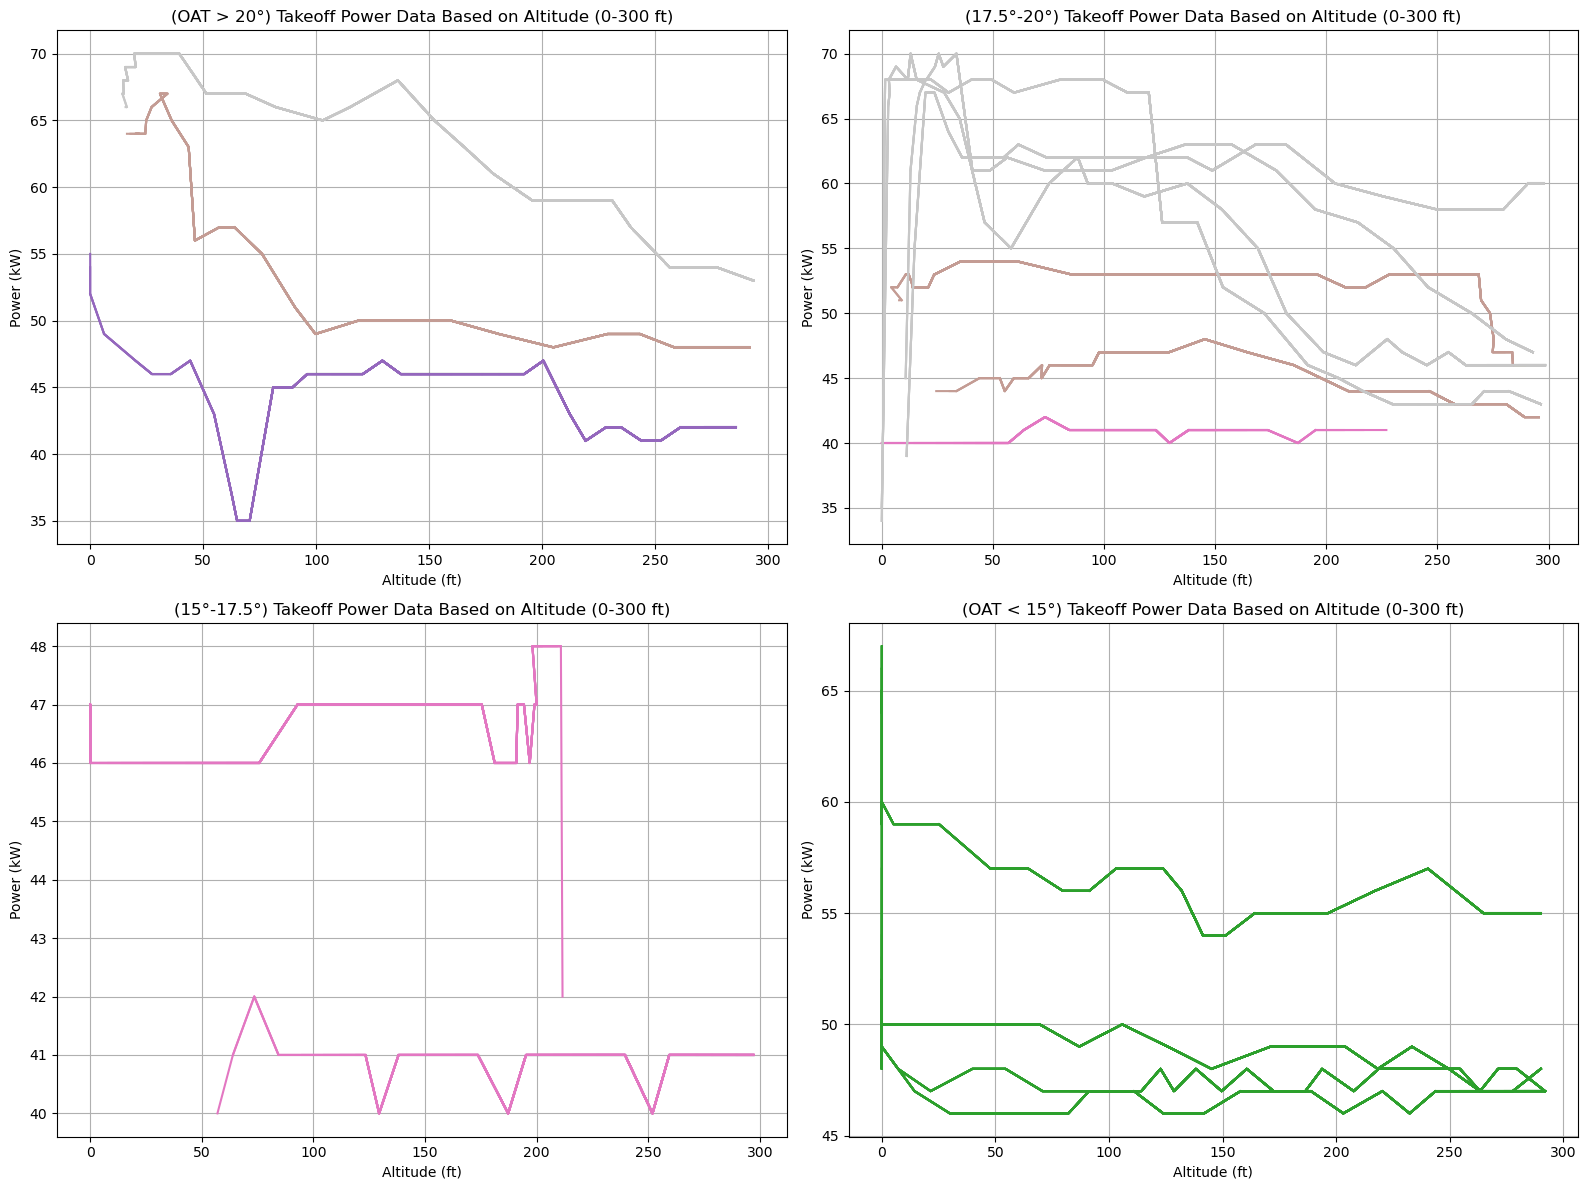

CPU times: total: 922 ms
Wall time: 4.06 s


In [14]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']

slopes_soc_per_ft = []
power_list_1 = []
power_list_2 = []
power_list_3 = []
power_list_4 = []

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = axes
powers = [0, 0, 0, 0]

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index

        if not high_slope_indices.empty:
            # Plots the data in between data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)

                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1

                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue

                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_oat = df_power["oat"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]

                mean_oat = np.mean(filtered_oat)
                if mean_oat > 20:
                    ax1.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_1.append(filtered_pwr.mean())
                elif 17.5 <= mean_oat <= 20:
                    ax2.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_2.append(filtered_pwr.mean())
                elif 15 <= mean_oat < 17.5:
                    ax3.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_3.append(filtered_pwr.mean())
                elif mean_oat < 15:
                    ax4.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_4.append(filtered_pwr.mean())

print('')
average_power_1 = round((abs(np.mean(power_list_1))), 3)
average_power_2 = round((abs(np.mean(power_list_2))), 3)
average_power_3 = round((abs(np.mean(power_list_3))), 3)
average_power_4 = round((abs(np.mean(power_list_4))), 3)
powers[0] = average_power_1
powers[1] = average_power_2
powers[2] = average_power_3
powers[3] = average_power_4

print(f"Average Power (OAT > 20°): {average_power_1} kW")
print(f"Average Power (17.5°-20°): {average_power_2} kW")
print(f"Average Power (15°-17.5°): {average_power_3} kW")
print(f"Average Power (OAT < 15°): {average_power_4} kW")
print("Plotting...")

# Configure the subplots
ax1.set_xlabel('Altitude (ft)')
ax1.set_ylabel('Power (kW)')
ax1.set_title('(OAT > 20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax1.grid(True)

ax2.set_xlabel('Altitude (ft)')
ax2.set_ylabel('Power (kW)')
ax2.set_title('(17.5°-20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax2.grid(True)

ax3.set_xlabel('Altitude (ft)')
ax3.set_ylabel('Power (kW)')
ax3.set_title('(15°-17.5°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax3.grid(True)

ax4.set_xlabel('Altitude (ft)')
ax4.set_ylabel('Power (kW)')
ax4.set_title('(OAT < 15°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax4.grid(True)

plt.tight_layout()
plt.show()

### Takeoff SoC Data

Processing file data/vancouver/flight/csv-25433-6054 [100%]
Plotting...


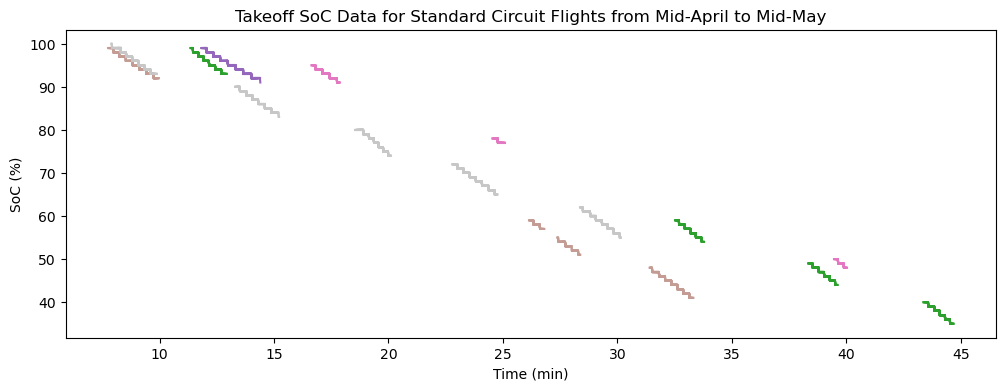

CPU times: total: 406 ms
Wall time: 2.51 s


In [15]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 11.277%/1000 ft
Plotting...


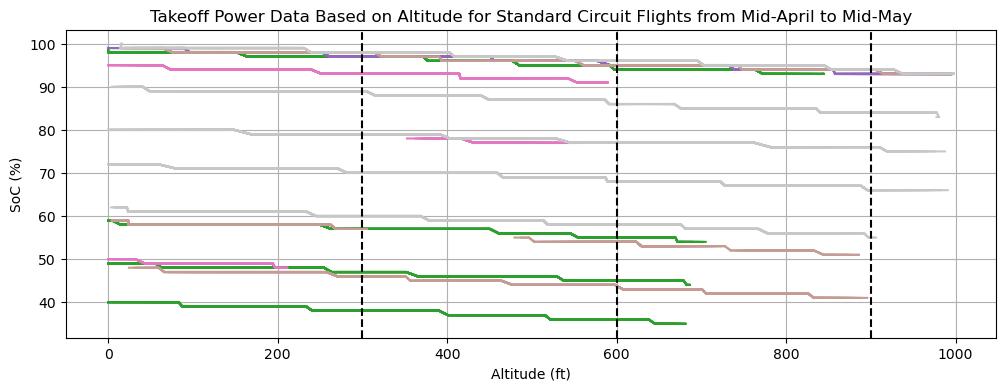

CPU times: total: 750 ms
Wall time: 2.66 s


In [16]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                time_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_time_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*1000
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/1000 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 1.619%/300 ft
Plotting...


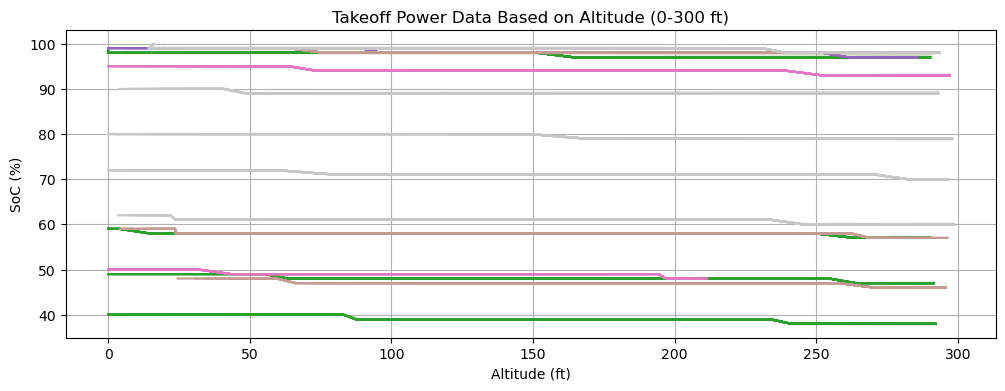

CPU times: total: 188 ms
Wall time: 1.82 s


In [17]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
                
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(alt_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))
                
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300 
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 2.411%/300 ft
Plotting...


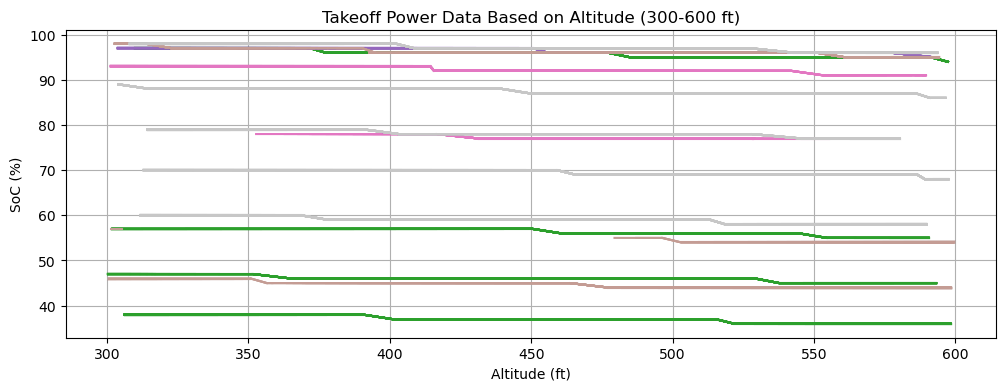

CPU times: total: 391 ms
Wall time: 2.14 s


In [18]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(soc_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/vancouver/flight/csv-25433-6054 [100%]
Average Slope of SoC per Altitude: 1.789%/300 ft
Plotting...


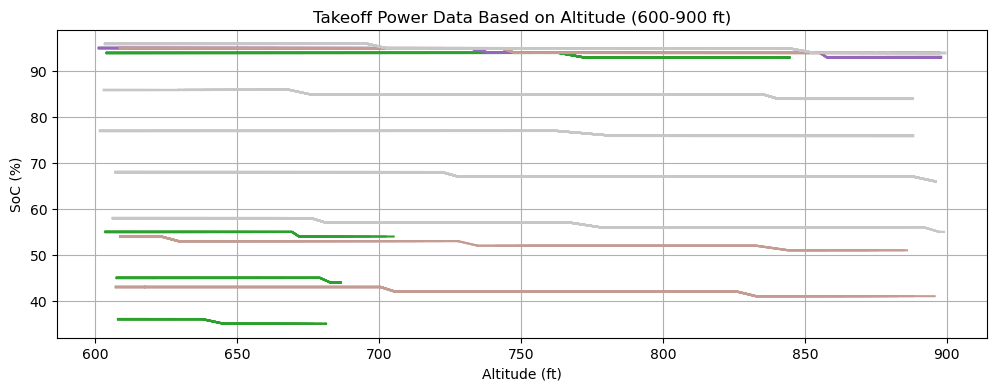

CPU times: total: 312 ms
Wall time: 1.91 s


In [19]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Average Total Energy Consumption

In [20]:
time_list = np.array(time_sum)
pwr_list = np.array(power_sum)
kWh_list = time_list*pwr_list/60
total_kWh = round((np.sum(kWh_list)),3)
print(f"Time per 300 ft:{time_list} min")
print(f"Average Power per 300 ft:{pwr_list} kW")
print(f"Divided Energy: {np.round(kWh_list,3)} kWh")
print(f"Total Energy: {total_kWh} kWh")
print(f"dSoC (At 75% SoH): {round((total_kWh/(24.8*0.75))*100,3)}%")

Time per 300 ft:[0.419 0.528 0.572] min
Average Power per 300 ft:[50.607 45.925 43.884] kW
Divided Energy: [0.353 0.404 0.418] kWh
Total Energy: 1.176 kWh
dSoC (At 75% SoH): 6.323%


## Current Code

#### Slope and Correlation Method

In [7]:
def calculate_slope_and_correlation(group, nrg = True):
    if len(group) < 2:
        return pd.Series({'Slope Linear': np.nan, 'R Linear': np.nan, 
                          'Slope Exponential': np.nan, 'R Exponential': np.nan})
    
    if nrg:
        x = group['Avg Power']
        y = group['Time']*group['Avg Power']/60
    else:
        x = group['Avg Power']
        y = group['Time']
    
    # Linear fit
    slope_linear = np.polyfit(x, y, 1)[0]
    correlation_matrix_linear = np.corrcoef(x, y)
    correlation_coefficient_linear = correlation_matrix_linear[0, 1]
    
    # Exponential fit (using logarithm of y)
    y_log = np.log(y)
    slope_exp = np.polyfit(x, y_log, 1)[0]
    correlation_matrix_exp = np.corrcoef(x, y_log)
    correlation_coefficient_exp = correlation_matrix_exp[0, 1]
    
    return pd.Series({'Slope Linear': slope_linear, 'R Linear': correlation_coefficient_linear,
                      'Slope Exponential': slope_exp, 'R Exponential': correlation_coefficient_exp})

#### Influence of initial power (rolling)

Processing file data/vancouver/flight/csv-25030-5911 [29%]

Processing file data/vancouver/flight/csv-25344-6022 [82%]
Plotting...


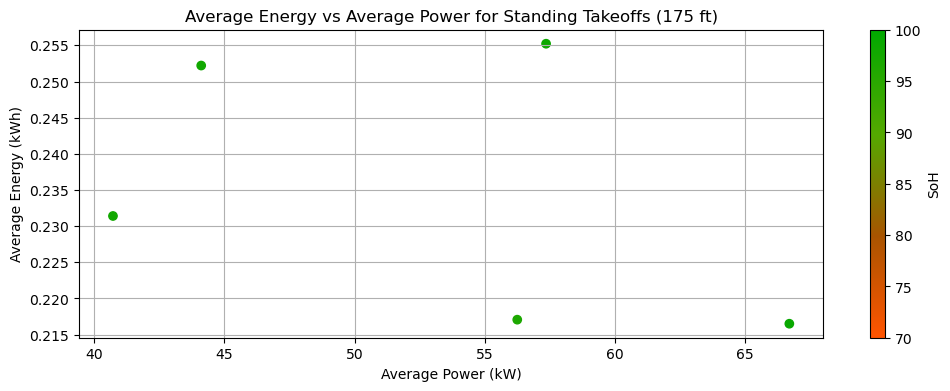

  SoH Bin  Slope Linear  R Linear  Slope Exponential  R Exponential
0   70-80           NaN       NaN                NaN            NaN
1   80-90           NaN       NaN                NaN            NaN
2  90-100     -0.000743 -0.422999          -0.003265      -0.436946
{56.25: (1, 'data/vancouver/flight/csv-25030-5911'), 44.111111111111114: (1, 'data/vancouver/flight/csv-25237-5983'), 57.357142857142854: (1, 'data/vancouver/flight/csv-25322-6016'), 40.72222222222222: (1, 'data/vancouver/flight/csv-25326-6018'), 66.7: (1, 'data/vancouver/flight/csv-25344-6022')}


C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\1446547215.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_15496\1446547215.py:157: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()


In [8]:
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the dictionary to store the value of each plotted energy point and the index of count_num to the subfolder name
energy_points_dict = {}

cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0]
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1300:
        print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
        test = False
        standing = True
        initial_range = True
        start_index = 0
        end_index = 0
        takeoff_count = 0
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff
        # Find the indices where slope is over 450
        high_slope_indices = slope[(abs(slope) > 400)].index
        plotted = False

        prev_mean = -100
        prev_start_idx = -100

        count_num = 1

        if not high_slope_indices.empty:
            # Plots the data in between data sufficient slope

            full_alt_data = df_power["alt"][i]
            full_time_data = df_power["time"][i]
            full_power_data = df_power["kw"][i]
            time_alt_slope = -100

            for idx in high_slope_indices:

                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)

                min_lim = 25
                max_lim = 175

                if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                    continue

                if df_power["alt"][i][end_idx] < min_lim:
                    continue

                if df_power["alt"][i][start_idx] > max_lim:
                    continue

                if df_power["alt"][i][start_idx] < min_lim:
                    if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                        continue
                    else:
                        start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx

                if df_power["alt"][i][end_idx] > max_lim:
                    end_idx = np.argmax(df_power["alt"][i] > max_lim)

                if start_idx >= end_idx:
                    continue

                alt_data = df_power["alt"][i][start_idx:end_idx]
                alt_mean = alt_data.mean(skipna=True)
                time_data = df_power["time"][i][start_idx:end_idx]
                end_time = df_power["time"][i][end_idx]

                if alt_mean < prev_mean or np.isnan(alt_mean):
                    if start_index + end_index > 0:
                        takeoff_count += 1
                        initial_range = True
                        start_index = df_power["alt"][i][start_index:end_index].idxmin()

                        diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                        diff_time = full_time_data[end_index] - full_time_data[start_index]
                        time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 300 ft from 175 ft
                        avg_power = full_power_data[start_index:end_index].mean()
                        oat = df_power["oat"][i][start_index:end_index].mean()
                        soh = df_power["soh"][i][start_index:end_index].mean()
                        if time_alt_slope < 0.8 and takeoff_count == count_num:  #
                            df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                            # Store the value and index in the dictionary
                            energy_points_dict[(avg_power)] = (count_num, subfolder)
                            plotted = True
                            initial_range = True

                if initial_range:
                    start_index = start_idx
                    if plotted:
                        prev_start_idx = start_index

                    if df_power["alt"][i][start_index] == 0:
                        pass
                    else:
                        initial_range = False

                end_index = end_idx
                prev_mean = alt_mean

            if start_index != prev_start_idx:
                if start_index + end_index > 0:
                    takeoff_count += 1
                    if takeoff_count == count_num:
                        initial_range = True
                        start_index = df_power["alt"][i][start_index:end_index].idxmin()

                        diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                        diff_time = full_time_data[end_index] - full_time_data[start_index]
                        time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 175 ft
                        avg_power = full_power_data[start_index:end_index].mean()
                        oat = df_power["oat"][i][start_index:end_index].mean()
                        soh = df_power["soh"][i][start_index:end_index].mean()
                        if time_alt_slope < 0.8:  # Eliminates Outliers
                            df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                            # Store the value and index in the dictionary
                            energy_points_dict[(avg_power)] = (count_num, subfolder)
                            initial_range = True

print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"] * df_slope["Avg Power"] / 60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

# Print the dictionary to verify its content
print(energy_points_dict)


Processing file data/waterloo/flight/csv-26897-6263_jun03_0920pm_dc [100%]
Plotting...


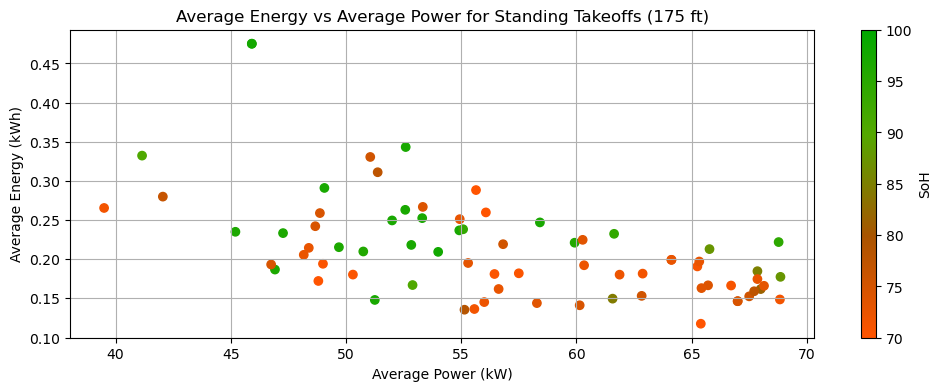

  SoH Bin     slope  correlation
0   70-80 -0.003725    -0.608726
1   80-90  0.002850     0.346593
2  90-100 -0.005176    -0.382672
{52.57142857142857: (1, 'data/waterloo/flight/csv-20815-4620_jun03_1011am_dc'), 58.416666666666664: (1, 'data/waterloo/flight/csv-20821-4622_jun04_1025am_dc'), 54.916666666666664: (1, 'data/waterloo/flight/csv-20821-4622_jun04_1025am_dc'), 49.0625: (1, 'data/waterloo/flight/csv-20871-4633_jun09_0237pm_dc'), 51.25: (1, 'data/waterloo/flight/csv-20882-4636_jun11_1012am_dc'), 52.0: (1, 'data/waterloo/flight/csv-21003-4669_jun21_1038am_dc'), 46.916666666666664: (1, 'data/waterloo/flight/csv-21443-4759_jul11_0956am_dc'), 52.833333333333336: (1, 'data/waterloo/flight/csv-21445-4714_jul05_0949am_dc'), 45.2: (1, 'data/waterloo/flight/csv-21465-4766_jul20_0954am_dc'), 47.266666666666666: (1, 'data/waterloo/flight/csv-21465-4766_jul20_0954am_dc'), 50.75: (1, 'data/waterloo/flight/csv-21504-4780_jul22_1000am_dc'), 49.69230769230769: (1, 'data/waterloo/flight/csv-2151

C:\Users\Nathan\AppData\Local\Temp\ipykernel_17688\1041863047.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_17688\1041863047.py:157: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()


In [ ]:
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the dictionary to store the value of each plotted energy point and the index of count_num to the subfolder name
energy_points_dict = {}

cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0]
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=70, vmax=100)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 400)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100

    count_num = 1

    if not high_slope_indices.empty:
        # Plots the data in between data sufficient slope

        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100

        for idx in high_slope_indices:

            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 175

            if df_power["time"][i][end_idx] < 5 or df_power["time"][i][start_idx] > 30:
                continue

            if df_power["alt"][i][end_idx] < min_lim:
                continue

            if df_power["alt"][i][start_idx] > max_lim:
                continue

            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx

            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)

            if start_idx >= end_idx:
                continue

            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]

            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()

                    diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                    diff_time = full_time_data[end_index] - full_time_data[start_index]
                    time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 300 ft from 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8 and takeoff_count > count_num:  #
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                        # Store the value and index in the dictionary
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        plotted = True
                        initial_range = True

            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index

                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False

            end_index = end_idx
            prev_mean = alt_mean

        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    initial_range = True
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()

                    diff_alt = full_alt_data[end_index] - full_alt_data[start_index]
                    diff_time = full_time_data[end_index] - full_time_data[start_index]
                    time_alt_slope = (diff_time / diff_alt) * 175  # Avg time to reach 175 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    if time_alt_slope < 0.8:  # Eliminates Outliers
                        df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH": soh}
                        # Store the value and index in the dictionary
                        energy_points_dict[(avg_power)] = (count_num, subfolder)
                        initial_range = True

print('')
print("Plotting...")

plt.scatter(df_slope["Avg Power"], df_slope["Time"] * df_slope["Avg Power"] / 60, marker='o', c=df_slope["SoH"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='SoH', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (175 ft)')
plt.grid(True)
plt.show()

bins = [70, 80, 90, 100]
labels = ['70-80', '80-90', '90-100']

df_slope['SoH Bin'] = pd.cut(df_slope['SoH'], bins=bins, labels=labels, right=False)

slopes_and_corr = df_slope.groupby('SoH Bin').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)

# Print the dictionary to verify its content
print(energy_points_dict)


Processing file data/waterloo/flight/csv-26897-6263_jun03_0920pm_dc [100%]
Plotting...


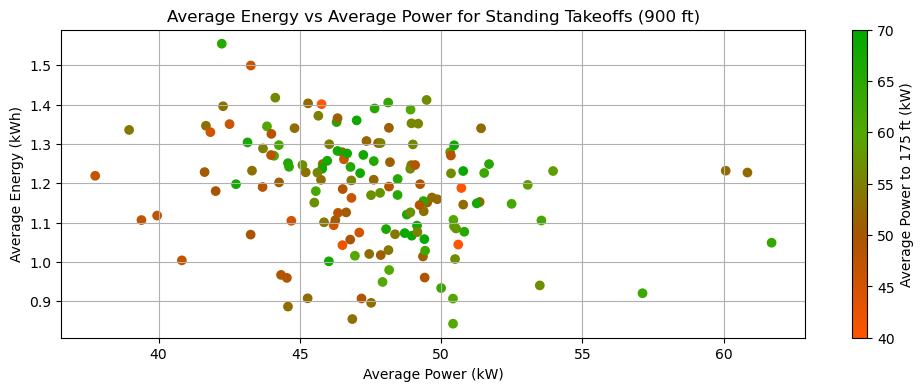

  Initial Power     slope  correlation
0         40-50 -0.003961    -0.094515
1         50-60 -0.007725    -0.184418
2         60-70 -0.020138    -0.558624
CPU times: total: 8.67 s
Wall time: 16.1 s


<timed exec>:165: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [ ]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
plt.figure(figsize=(12, 4))

colors = [(1, 0.33, 0), (0.66, 0.33, 0), (0.33, 0.66, 0), (0, 0.66, 0)]  # Green to Blue
nodes = [0.0, 0.33, 0.66, 1.0] 
custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", list(zip(nodes, colors)))
norm = mcolors.Normalize(vmin=40, vmax=70)

slopes_ft_per_min = []
test = []
count = 0
df_slope = pd.DataFrame(columns=['Avg Power', 'Time', 'Average OAT', 'SoH', 'Average Batt Temp', 'Initial Power'])

for i, subfolder in enumerate(subfolders):

    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    test = False
    standing = True
    initial_range = True
    start_index = 0
    end_index = 0
    takeoff_count = 0
    # Calculates the slope of cells 100 cells away from each other
    alt_diff = df_power["alt"][i].diff(periods=cell_diff)
    time_diff = df_power["time"][i].diff(periods=cell_diff)
    temp_alt_diff = df_power["alt"][i].diff(periods=10)
    alt_diff[temp_alt_diff < 0] = 0
    slope = alt_diff / time_diff 
    # Find the indices where slope is over 450
    high_slope_indices = slope[(abs(slope) > 400)].index
    plotted = False

    prev_mean = -100
    prev_start_idx = -100
    
    count_num = 1
    
    if not high_slope_indices.empty:
        # Plots the data inbtwn data sufficient slope
        
        full_alt_data = df_power["alt"][i]
        full_time_data = df_power["time"][i]
        full_power_data = df_power["kw"][i]
        time_alt_slope = -100
        
        for idx in high_slope_indices:
            
            start_idx = max(0, idx - cell_diff + 1)
            end_idx = min(len(df_power["alt"][i]), idx + 1)

            min_lim = 25
            max_lim = 900
            
            if df_power["time"][i][end_idx] < 5:
                continue
            
            if df_power["alt"][i][end_idx] < min_lim:
                continue
            
            if df_power["alt"][i][start_idx] > max_lim:
                continue
            
            if df_power["alt"][i][start_idx] < min_lim:
                if np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) == 0:
                    continue
                else:
                    start_idx = np.argmax(df_power["alt"][i][start_idx:end_idx] > min_lim) + start_idx


            if df_power["alt"][i][end_idx] > max_lim:
                end_idx = np.argmax(df_power["alt"][i] > max_lim)
                
            
            if start_idx >= end_idx:
                continue
            
            alt_data = df_power["alt"][i][start_idx:end_idx]
            alt_mean = alt_data.mean(skipna=True)
            time_data = df_power["time"][i][start_idx:end_idx]
            end_time = df_power["time"][i][end_idx]
            
            if alt_mean < prev_mean or np.isnan(alt_mean):
                if start_index + end_index > 0:
                    takeoff_count += 1
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                    
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft from 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and takeoff_count > count_num and avg_power > 0: #
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                plotted = True
                                initial_range = True
                                break
                
            if initial_range:
                start_index = start_idx
                if plotted:
                    prev_start_idx = start_index
                
                if df_power["alt"][i][start_index] == 0:
                    pass
                else:
                    initial_range = False
                
            
            end_index = end_idx
            prev_mean = alt_mean
            
        if start_index != prev_start_idx:
            if start_index + end_index > 0:
                takeoff_count += 1
                if takeoff_count > count_num:
                    start_index = df_power["alt"][i][start_index:end_index].idxmin()
                
                    diff_alt = full_alt_data[end_index]-full_alt_data[start_index]
                    diff_time = full_time_data[end_index]-full_time_data[start_index]
                    time_alt_slope = (diff_time/diff_alt) * 900 # Avg time to reach 900 ft
                    avg_power = full_power_data[start_index:end_index].mean()
                    oat = df_power["oat"][i][start_index:end_index].mean()
                    soh = df_power["soh"][i][start_index:end_index].mean()
                    battT = df_power["battT"][i][start_index:end_index].mean()
                    if time_alt_slope < 3 and avg_power > 0: #Eliminates Outliers
                        target_tuple = (count_num, subfolder)
                        for key, value in energy_points_dict.items():
                            if value == target_tuple:
                                df_slope.loc[len(df_slope)] = {"Avg Power": avg_power, "Time": time_alt_slope, "Average OAT": oat, "SoH":soh, "Average Batt Temp": battT, "Initial Power": key}
                                # plt.plot(full_time_data[start_index:end_index], full_alt_data[start_index:end_index], color=colormap(i / total_subfolders))
                                initial_range = True
                                break


                        
                        
                                
  
print('')
print("Plotting...")

# Save this for later
plt.scatter(df_slope["Avg Power"], df_slope["Time"]*df_slope["Avg Power"]/60, marker='o', c=df_slope["Initial Power"], cmap=custom_colormap, norm=norm)
plt.colorbar(label='Average Power to 175 ft (kW)', cmap=custom_colormap, norm=norm)

plt.xlabel('Average Power (kW)')
plt.ylabel('Average Energy (kWh)')
plt.title('Average Energy vs Average Power for Standing Takeoffs (900 ft)')
plt.grid(True)
plt.show()

bins = [40, 50, 60, 70]
labels = ['40-50', '50-60', '60-70']

df_slope['Initial Power'] = pd.cut(df_slope['Initial Power'], bins=bins, labels=labels, right=False)


slopes_and_corr = df_slope.groupby('Initial Power').apply(calculate_slope_and_correlation).reset_index()

print(slopes_and_corr)